This notebook contains the code required to reproduce the hierarchical MFU polynomial example in the paper.

In [1]:
import os, sys
import numpy as np
from matplotlib import rcParams
rcParams['text.usetex'] = True
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times']
rcParams['text.latex.preamble'] = r'\usepackage{amssymb}'
import matplotlib.pyplot as plt
import scipy.stats as ss
import emcee
import pandas as pd
from SobolIndices import *

In [2]:
results_dir = 'results/polynomial_MFU_example/'
if not os.path.exists(results_dir): os.mkdir(results_dir)

# Create calibration data

The underlying signal for the data comes from
$$
f_{true}(x) = c_0 + c_1 x + 0.1(x^2 + x^3), \quad x \in [0,2].
$$

In [3]:
x = np.linspace(0,2, 1001, endpoint=True)

c0 = 1.
c1 = 1.
ftrue = c0 + c1*x + 0.1*(x**2 + x**3)

Downselecting to every 10 spatial points for the data.

In [4]:
data_ftrue = ftrue[::10]
data_x = x[::10]

We assume a likelihood of
$$
d_i = f_{true}(x_i) + \epsilon_i, \quad \epsilon_i \sim \mathcal{N}(0, (0.05)^2), \quad i=1,\ldots,101
$$

In [5]:
np.random.seed(20240222)
measurement_sd = 0.05
measurement_rv = ss.norm(0,measurement_sd)
data = data_ftrue + measurement_rv.rvs(data_ftrue.size) 

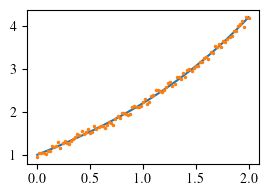

In [6]:
plt.figure(figsize=(3,2))
plt.plot(x,ftrue)
plt.plot(data_x,data,'.', ms=3)

## Bayesian calibration, inadequate model

In [7]:
def flin(theta, x=data_x):
    c0, c1 = theta
    return c0 + c1*x

In [8]:
def log_lhood(theta):
    return np.sum(measurement_rv.logpdf(data-flin(theta)))

In [9]:
c0_rv = ss.uniform(0,scale=2)
c1_rv = ss.uniform(0,scale=5)
def log_prior(theta):
    c0, c1 = theta
    return c0_rv.logpdf(c0) + c1_rv.logpdf(c1)

<ErrorbarContainer object of 3 artists>

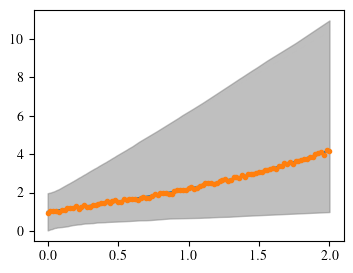

In [10]:
prior_pushforward_samples = np.array([c0_rv.rvs(1000),c1_rv.rvs(1000)]).T
pri_p = np.zeros((prior_pushforward_samples.shape[0], x.size))
for i, theta in enumerate(prior_pushforward_samples):
    pri_p[i,:] = flin(theta, x=x) + measurement_rv.rvs()

pri_p_q5, pri_p_q95 = np.quantile(pri_p, q=(0.025, 0.975), axis=0)
pri_p_mean = pri_p.mean(axis=0)

fig = plt.figure(figsize=(4,3))
plt.fill_between(x, pri_p_q5, pri_p_q95, color='grey', alpha=0.5)
plt.plot(x,ftrue)
plt.errorbar(data_x, data, yerr=2*measurement_sd, fmt='.')

In [11]:
def log_post(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return lp
    else:
        ll = log_lhood(theta)
        return ll+lp

In [12]:
theta0 = np.array([ c0_rv.mean(), c1_rv.mean()])
theta0

array([1. , 2.5])

In [13]:
np.random.seed(20230223)
nwalkers = 2*theta0.size
pos = theta0 + 1e-3 * np.random.randn(nwalkers, theta0.size)

In [14]:
sampler = emcee.EnsembleSampler(nwalkers, theta0.size, log_post)

In [15]:
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:02<00:00, 2126.53it/s]


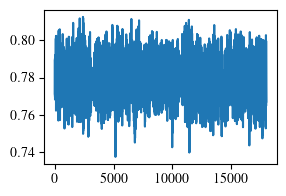

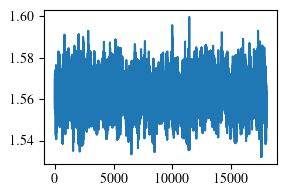

In [16]:
samples = sampler.get_chain(discard=500,flat=True)

for s in samples.T:
    plt.figure(figsize=(3,2))
    plt.plot(s)

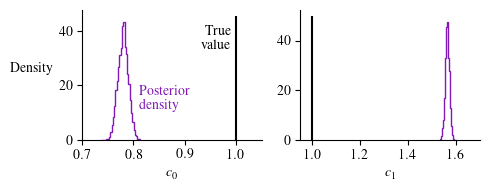

In [17]:
fig = plt.figure(figsize=(5,2))
axs = fig.subplots(1,2)
axs[0].hist(samples[:,0], bins=30, histtype='step', density=True, color='#8119b5');
axs[1].hist(samples[:,1], bins=30, histtype='step', density=True, color='#8119b5');

for ax in axs:
    ax.vlines(1,0, ax.get_ylim()[1], 'k')
    ax.spines[['top','right']].set_visible(False)

axs[0].set_xlim([0.7, 1.05])
axs[1].set_xlim([0.95, 1.7])

axs[0].set_ylabel('Density', rotation=0, ha='right')
axs[0].set_xlabel(r'$c_0$')
axs[1].set_xlabel(r'$c_1$')

axs[0].annotate('True\nvalue', (0.99, 42), ha='right', va='top')
axs[0].annotate('Posterior\ndensity', (0.81, 20), ha='left', va='top', color='#8119b5')
fig.tight_layout()
fig.savefig(f'{results_dir}/linear_post_vs_true.png', dpi=300, transparent=True)

In [18]:
posterior_pushforward_samples = samples[::100]
pp = np.zeros((posterior_pushforward_samples.shape[0], x.size))
for i, theta in enumerate(posterior_pushforward_samples):
    pp[i,:] = flin(theta, x=x) + measurement_rv.rvs(x.size)
pp_q5, pp_q95 = np.quantile(pp, q=(0.025, 0.975), axis=0)
pp_mean = np.mean(pp, axis=0)

In [19]:
x.shape, pri_p_q95.shape

((1001,), (1001,))

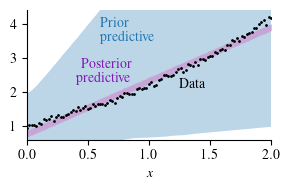

In [20]:
fig = plt.figure(figsize=(3,2))
ax = fig.add_subplot(111)
ax.fill_between(x, pri_p_q5, pri_p_q95, color='#bcd5e7', lw=0)
ax.fill_between(x, pp_q5, pp_q95, color='#c7a5d6', lw=0)
ax.plot(data_x, data, 'k.', ms=2)
ax.set_xlim([0,2])
ax.set_ylim([0.9*min(np.min(pp_q5), np.min(data)), 1.1*min(np.max(pp_q95), np.max(data))])
ax.set_xlabel(r'$x$')

ax.annotate('Prior\npredictive', (0.6, 4.2), ha='left', va='top', color='C0')
ax.annotate('Posterior\npredictive', (0.85, 3), ha='right', va='top', color='#8119b5')
ax.annotate('Data', (1.25,2.4), va='top')

ax.spines[['top','right']].set_visible(False)
fig.tight_layout()
fig.savefig(f'{results_dir}/linear_predictives_vs_data.png', dpi=300, transparent=True)

## Calibrating model + MFU representation

In [21]:
c0_rv = ss.uniform(0,scale=2)
c1_rv = ss.uniform(0,scale=5)

c2_mu_rv = ss.norm(-1,scale=.5)
c2_sigma_rv = ss.uniform(0,scale=0.1)

alpha_mu_rv = ss.norm(0,0.5)
alpha_sigma_rv = ss.uniform(0, scale=0.1)

In [22]:
def fhier(theta, x=data_x):
    c0, c1, c2, alpha = theta[:4]
    c2s = np.exp(c2)
    alphas = 1+np.exp(alpha)
    return c0 + c1*x + c2s*np.power(x, alphas)

In [23]:
c0_samples = c0_rv.rvs(5000)
c1_samples = c1_rv.rvs(5000)

mu_samples = c2_mu_rv.rvs(5000)
sigma_samples = c2_sigma_rv.rvs(5000)
c2_samples = np.zeros(5000)
for i, (mu,sigma) in enumerate(zip(mu_samples, sigma_samples)):
    c2_samples[i] = ss.norm(mu, sigma).rvs()

mu_samples = alpha_mu_rv.rvs(5000)
sigma_samples = alpha_sigma_rv.rvs(5000)
alpha_samples = np.zeros(5000)
for i, (mu,sigma) in enumerate(zip(mu_samples,sigma_samples)):
    alpha_samples[i] = ss.norm(mu,sigma).rvs()


In [24]:
def log_prior_hierarch(theta):
    c0, c1, c2, alpha, c2_mu, c2_sigma, alpha_mu, alpha_sigma = theta

    lp = c0_rv.logpdf(c0)
    lp += c1_rv.logpdf(c1)
    lp += c2_mu_rv.logpdf(c2_mu)
    lp += c2_sigma_rv.logpdf(c2_sigma)
    lp += alpha_mu_rv.logpdf(alpha_mu)
    lp += alpha_sigma_rv.logpdf(alpha_sigma)

    c2_rv = ss.norm(c2_mu, scale=c2_sigma)
    lp += c2_rv.logpdf(c2)

    alpha_rv = ss.norm(alpha_mu, scale=alpha_sigma)
    lp += alpha_rv.logpdf(alpha)

    return lp

In [25]:
def log_lhood_hierarch(theta):
    return np.sum(measurement_rv.logpdf(data-fhier(theta)))

In [26]:
def log_post_hierarch(theta):
    lp = log_prior_hierarch(theta)
    ll = log_lhood_hierarch(theta)
    lpo = lp + ll
    if not np.isfinite(lpo):
        return -np.inf
    return lpo

In [27]:
np.random.seed(20240412)
c0_samples = c0_rv.rvs(5000)
c1_samples = c1_rv.rvs(5000)

mu_samples = c2_mu_rv.rvs(5000)
sigma_samples = c2_sigma_rv.rvs(5000)
c2_samples = np.zeros(5000)
for i, (mu,sigma) in enumerate(zip(mu_samples, sigma_samples)):
    c2_samples[i] = ss.norm(mu, sigma).rvs()
temp = np.exp(c2_samples)

In [28]:
np.random.seed(20240412)
mu_samples = alpha_mu_rv.rvs(5000)
sigma_samples = alpha_sigma_rv.rvs(5000)
alpha_samples = np.zeros(5000)
for i, (mu,sigma) in enumerate(zip(mu_samples,sigma_samples)):
    alpha_samples[i] = ss.norm(mu,sigma).rvs()
temp = 1+np.exp(alpha_samples)

<ErrorbarContainer object of 3 artists>

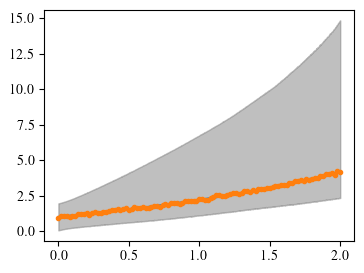

In [29]:
f_samples = np.zeros((alpha_samples.size, x.size))
for i, theta in enumerate(zip(c0_samples, c1_samples, c2_samples, alpha_samples)):
    f_samples[i,:] = fhier(theta, x=x) + measurement_rv.rvs(x.size)
prp_q5, prp_q95 = np.quantile(f_samples, q=(0.025, 0.975), axis=0)

fig = plt.figure(figsize=(4,3))
plt.fill_between(x, prp_q5, prp_q95, color='grey', alpha=0.5)
plt.plot(x, ftrue)
plt.errorbar(data_x, data, yerr=2*measurement_sd, fmt='.')

In [30]:
theta0 = np.array([ 0.5, 0.5, c2_mu_rv.mean(), alpha_mu_rv.mean(), c2_mu_rv.mean(), c2_sigma_rv.mean(), alpha_mu_rv.mean(), alpha_sigma_rv.mean()])
theta0

array([ 0.5 ,  0.5 , -1.  ,  0.  , -1.  ,  0.05,  0.  ,  0.05])

In [31]:
np.random.seed(20230223)
nwalkers = 2*theta0.size
pos = theta0 + 1e-4 * np.random.randn(nwalkers, theta0.size)
sampler = emcee.EnsembleSampler(nwalkers, theta0.size, log_post_hierarch)

In [32]:
sampler.run_mcmc(pos, 10000, progress=True);

100%|██████████| 10000/10000 [02:07<00:00, 78.70it/s]


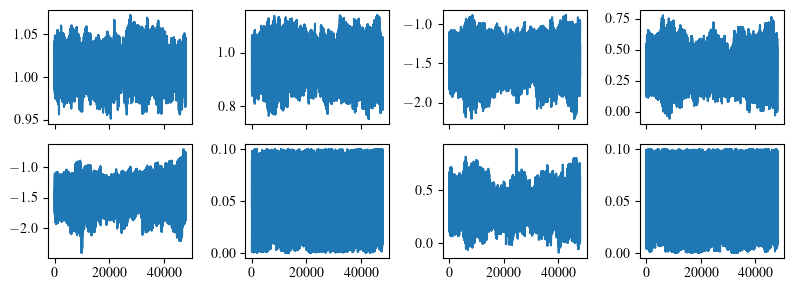

In [33]:
samples = sampler.get_chain(discard=7000,flat=True)
fig = plt.figure(figsize=(8,3))
axs = fig.subplots(2,4,sharex=True).flatten()
for s, ax in zip(samples.T,axs):
    ax.plot(s)
fig.tight_layout()

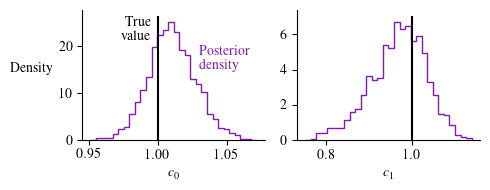

In [34]:
fig = plt.figure(figsize=(5,2))
axs = fig.subplots(1,2)

axs[0].hist(samples[:,0], histtype='step', density=True, bins=30, color='#8119b5');
axs[1].hist(samples[:,1], histtype='step', bins=30, density=True, color='#8119b5');

for ax in axs:
    ax.vlines(1,0, ax.get_ylim()[1], 'k')
    ax.spines[['top','right']].set_visible(False)

axs[0].set_ylabel('Density', rotation=0, ha='right')
axs[0].set_xlabel(r'$c_0$')
axs[1].set_xlabel(r'$c_1$')

axs[0].annotate('True\nvalue', (0.995, 0.95*axs[0].get_ylim()[1]), ha='right', va='top')
axs[0].annotate('Posterior\ndensity', (1.03, 20), ha='left', va='top', color='#8119b5')

fig.tight_layout()
fig.savefig(f'{results_dir}/MFU_post_vs_true.png', dpi=300, transparent=True)    

In [35]:
def hierarchical_resample( samples ):
    # Assumes it's given an array of samples of shape N x 8 
    # where the columsn are ordered as
    # [ c0, c1, c2, alpha, c2mean, c2sigma, alphamean, alphasigma]
    # It's going to take the hyperparameter samples and resample c2 and alpha

    hierarchical_resample = samples.copy()
    c2mus, c2sigmas, alphamus, alphasigmas = samples[:,-4:].T
    for i, (c2mu, c2sigma, alphamu, alphasigma) in enumerate(zip(c2mus, c2sigmas, alphamus, alphasigmas)):
        hierarchical_resample[i,2] = ss.norm(c2mu, c2sigma).rvs()
        hierarchical_resample[i,3] = ss.norm(alphamu, alphasigma).rvs()
    return hierarchical_resample

In [36]:
pps = hierarchical_resample(samples[::10])
ppf = np.zeros((pps.shape[0], x.size))
for i, s in enumerate(pps):
    ppf[i,:] = fhier(s, x=x) + measurement_rv.rvs(x.size)

pp_q5, pp_q95 = np.quantile(ppf, q=(0.025, 0.975), axis=0)
pp_mean = ppf.mean(axis=0)

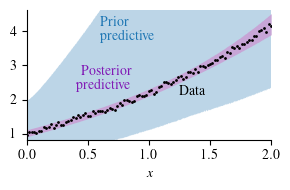

In [37]:
fig = plt.figure(figsize=(3,2))
ax = fig.add_subplot(111)
ax.fill_between(x, prp_q5, prp_q95, color='#bcd5e7', lw=0)
ax.fill_between(x, pp_q5, pp_q95, color='#c7a5d6', lw=0)
ax.plot(data_x, data, 'k.', ms=2)
ax.set_xlim([0,2])
ax.set_ylim([0.9*min(np.min(pp_q5), np.min(data)), 1.1*min(np.max(pp_q95), np.max(data))])
ax.set_xlabel(r'$x$')

ax.annotate('Prior\npredictive', (0.6, 4.45), ha='left', va='top', color='C0')
ax.annotate('Posterior\npredictive', (0.85, 3), ha='right', va='top', color='#8119b5')
ax.annotate('Data', (1.25,2.4), va='top')

ax.spines[['top','right']].set_visible(False)
fig.tight_layout()
fig.savefig(f'{results_dir}/mfu_predictives_vs_data.png', dpi=300, transparent=True)

How correlated are the model and MFU parameters?

    c0, c1, c2, alpha, c2_mu, c2_sigma, alpha_mu, alpha_sigma = theta

In [38]:
df = pd.DataFrame(pps[:,[0,1,4,5,6,7]], columns=['c0', 'c1', 'c2mu', 'c2sigma', 'alphamu', 'alphasigma' ])
cc = df.corr().iloc[:2,2:]
cc

,c2mu,c2sigma,alphamu,alphasigma
c0,0.666069,-0.017830,-0.569267,0.038491
c1,-0.938122,-0.021391,0.849532,-0.031059


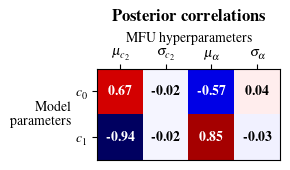

In [39]:
fig = plt.figure(figsize=(3,2))
ax = fig.add_subplot(111)
ax.matshow(cc, vmin=-1, vmax=1, cmap='seismic')
ax.set_yticks([0,1])
ax.set_yticklabels([r'$c_0$', r'$c_1$']);
ax.set_xticks(np.arange(4))
ax.set_xticklabels([r'$\mu_{c_2}$', r'$\sigma_{c_2}$', r'$\mu_\alpha$', r'$\sigma_\alpha$' ]);
ax.tick_params(axis='x', bottom=False)

for i in range(2):
    for j in range(4):
        val = cc.iloc[i,j]
        color = 'w' if np.abs(val) > 0.2 else 'k'
        ax.annotate(rf'\textbf{{{cc.iloc[i,j]:.2f}}}', (j,i), ha='center', va='center', color=color)

ax.set_ylabel('Model\nparameters', rotation=0, ha='right', va='center')
ax.set_xlabel('MFU hyperparameters')
ax.xaxis.set_label_position('top')  

ax.set_title(r'\textbf{Posterior correlations}', pad=8);
fig.tight_layout()
fig.savefig(f'{results_dir}/MFU_posterior_correlations.png', dpi=300, transparent=True)

# Sobol indices

Since we're working with correlated samples, we're going to work with total effects indices. 

We want to be able to compare the prior sensitivities to the posterior ones.

### Posterior KDE
We can generate prior samples easily enough, but we will want to build a KDE of the posterior samples so we can resample in larger numbers.

In [40]:
KDE_samples = pps[:,[0,1,4,5,6,7]] # Extracting just model and hyperparameters

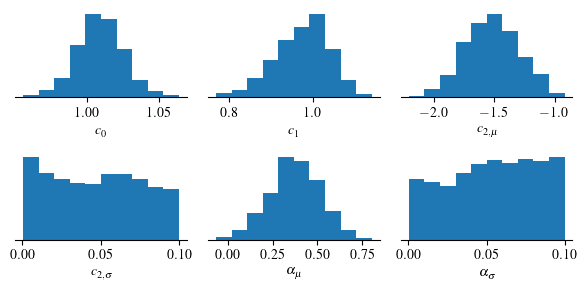

In [41]:
fig = plt.figure(figsize=(6,3))
axs = fig.subplots(2,3).flatten()
xlabels = [r'$c_0$', r'$c_1$', r'$c_{2,\mu}$', r'$c_{2,\sigma}$', r'$\alpha_\mu$', r'$\alpha_\sigma$' ]
for i, (k,ax,xlabel) in enumerate(zip(KDE_samples.T,axs, xlabels)):
    ax.hist(k)
    ax.set_yticks([])
    ax.spines[['top','left','right']].set_visible(False)
    ax.set_xlabel(xlabel)
fig.tight_layout()

Since the $\sigma$ hyperparameters are uniformly distributed, we need to rescale them so they're suitable for fitting a KDE to them. We'll rescale them to $[0,1]$ then pass them through the inverse CDF of a standard normal to get them in an unbounded domain.

In [42]:
sn_rv = ss.norm()
KDE_samples[:,[-3,-1]] /= 0.1
KDE_samples[:,[-3,-1]] = sn_rv.ppf(KDE_samples[:,[-3,-1]])

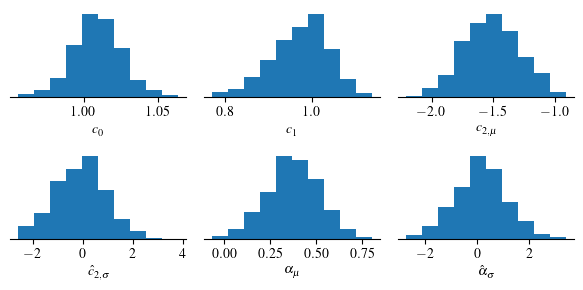

In [43]:
fig = plt.figure(figsize=(6,3))
axs = fig.subplots(2,3).flatten()
xlabels = [r'$c_0$', r'$c_1$', r'$c_{2,\mu}$', r'$\hat{c}_{2,\sigma}$', r'$\alpha_\mu$', r'$\hat{\alpha}_\sigma$' ]
for i, (k,ax,xlabel) in enumerate(zip(KDE_samples.T,axs, xlabels)):
    ax.hist(k)
    ax.set_yticks([])
    ax.spines[['top','left','right']].set_visible(False)
    ax.set_xlabel(xlabel)
fig.tight_layout()

Now that we've done this transform we can construct the KDE.

In [44]:
kde = ss.gaussian_kde(KDE_samples.T)

Let's confirm the fit is good.

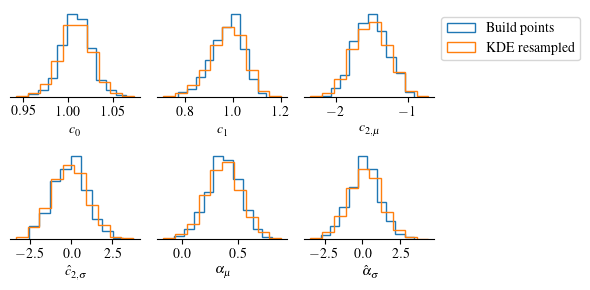

In [45]:
fig = plt.figure(figsize=(6,3))
axs = fig.subplots(2,3).flatten()
xlabels = [r'$c_0$', r'$c_1$', r'$c_{2,\mu}$', r'$\hat{c}_{2,\sigma}$', r'$\alpha_\mu$', r'$\hat{\alpha}_\sigma$' ]

KDE_resamples = kde.resample(KDE_samples.shape[0])

for i, (k,kr, ax,xlabel) in enumerate(zip(KDE_samples.T, KDE_resamples, axs, xlabels)):
    ax.hist(k, histtype='step', density=True, label='Build points');
    ax.hist(kr, histtype='step', density=True, label='KDE resampled');
    ax.set_yticks([])
    ax.spines[['top','left','right']].set_visible(False)
    ax.set_xlabel(xlabel)

axs[2].legend(bbox_to_anchor=(1,1))
fig.tight_layout()

This is looking pretty good, but let's do some corner plots.

/var/folders/lg/ppkr685x7ks4rkvrpfbsh36c00318j/T/ipykernel_37236/954759318.py:21: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  fig.tight_layout()


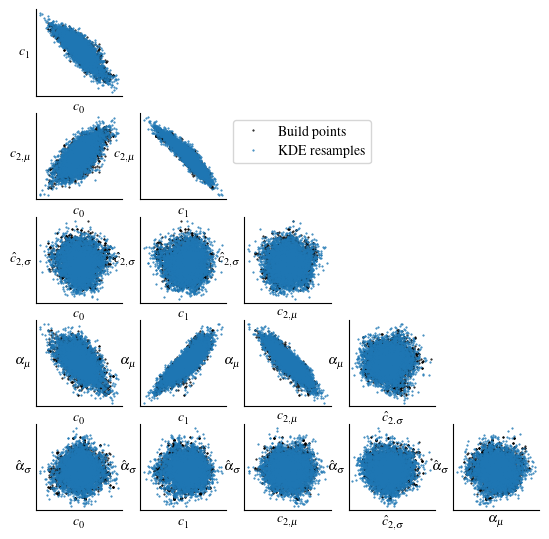

In [46]:
fig = plt.figure(figsize=(6.5,6.5))
axs = fig.subplots(5,5)
for i, (sample1, sample1r, label1) in enumerate(zip(KDE_samples[:,:-1].T, KDE_resamples[:-1], xlabels[:-1])):
    for j, (sample2, sample2r, label2) in enumerate(zip(KDE_samples[:,1:].T, KDE_resamples[1:], xlabels[1:])):

        ax = axs[j,i]
        if i > j:
            plt.delaxes(ax)

        ax.plot(sample1, sample2, 'k.', ms=1, label='Build points')
        ax.plot(sample1r, sample2r, 'C0.', ms=1, label='KDE resamples')
        ax.set_xlabel(label1)
        ax.set_ylabel(label2, rotation=0, ha='right', va='center')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_box_aspect(1)
        ax.spines[['top','right']].set_visible(False)

axs[1,1].legend(bbox_to_anchor=(1,1))

fig.tight_layout()

Fit is good. We can use this KDE for resampling the posterior.

### Sobol class definition

To use the SobolIndex class capabilities we have to inherit from the class. 

In [47]:
class MFUSobol(SobolIndices):
    def __init__(self, x=data_x):
        self.model_params = [r'$c_0$', r'$c_1$']
        self.MFU_params = [r'$c_2$', r'$\alpha$', r'$c_{2,\mu}$', r'$\hat{c}_{2,\sigma}$', r'$\alpha_\mu$', r'$\hat{\alpha}_\sigma$' ]

        SobolIndices.__init__(self,parameter_groups=[self.model_params, self.MFU_params])

        # Overwriting from defaults in SobolIndices
        self.x = np.atleast_1d(np.array(x))
        self.n_outputs = self.x.size
        self.output_names = [f'f({xi})' for xi in self.x ]

    def fX( self, X ):
        c0s, c1s, c2s, alphas = X[:,:4].T
        c2s = np.exp(c2s)
        alphas = 1+np.exp(alphas)
        y = c0s + c1s*self.x[:,np.newaxis] + c2s*np.power(self.x[:,np.newaxis], alphas)
        return y.T
    
def generate_prior_samples(N):
    X = np.zeros((N,8))
    
    # sample model parameters
    X[:,0] = c0_rv.rvs(N)
    X[:,1] = c1_rv.rvs(N)

    # sample hyperparameters
    X[:,-4] = c2_mu_rv.rvs(N)
    X[:,-3] = c2_sigma_rv.rvs(N)
    X[:,-2] = alpha_mu_rv.rvs(N)
    X[:,-1] = alpha_sigma_rv.rvs(N)

    #sample MFU parameters
    for i, (c2mu, c2sigma, alphamu, alphasigma) in enumerate(X[:,-4:]):
        X[i,2] = ss.norm(c2mu, c2sigma).rvs()
        X[i,3] = ss.norm(alphamu, alphasigma).rvs()
    
    return X

def generate_posterior_samples(N):
    X = np.zeros((N,8))
    
    # sample model parameters and hyperparameters
    X[:,[0,1,4,5,6,7]] = kde.resample(size=N).T

    # Now we need to scale these back to the appropriate values
    alpha_inds = [5,7]
    X[:,alpha_inds] = sn_rv.cdf(X[:,alpha_inds]) * 0.1

    #sample MFU parameters
    for i, (c2mu, c2sigma, alphamu, alphasigma) in enumerate(X[:,-4:]):
        X[i,2] = ss.norm(c2mu, c2sigma).rvs()
        X[i,3] = ss.norm(alphamu, alphasigma).rvs()

    return X

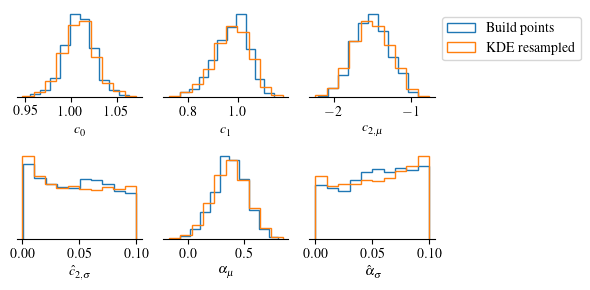

In [48]:
X = generate_posterior_samples(pps.shape[0])

fig = plt.figure(figsize=(6,3))
axs = fig.subplots(2,3).flatten()
xlabels = [r'$c_0$', r'$c_1$', r'$c_{2,\mu}$', r'$\hat{c}_{2,\sigma}$', r'$\alpha_\mu$', r'$\hat{\alpha}_\sigma$' ]

for i, (k,kr, ax,xlabel) in enumerate(zip(pps[:,[0,1,4,5,6,7]].T, X[:,[0,1,4,5,6,7]].T, axs, xlabels)):
    ax.hist(k, histtype='step', density=True, label='Build points');
    ax.hist(kr, histtype='step', density=True, label='KDE resampled');
    ax.set_yticks([])
    ax.spines[['top','left','right']].set_visible(False)
    ax.set_xlabel(xlabel)

axs[2].legend(bbox_to_anchor=(1,1))
fig.tight_layout()

### Prior sampling

First, let's compute Sobol' indices for prior samples.

In [49]:
N = 100000
mprior = MFUSobol()

np.random.seed(20250705)
A = generate_prior_samples(N)
B = generate_prior_samples(N)
mprior.compute_sobol_indices(sample_tup=(A,B))

Iteration over group: 100%|██████████| 2/2 [00:00<00:00,  5.78it/s]


### Posterior sampling

In [50]:
N = 100000
mposterior = MFUSobol()

np.random.seed(20250705)
A = generate_posterior_samples(N)
B = generate_posterior_samples(N)
mposterior.compute_sobol_indices(sample_tup=(A,B))

Iteration over group: 100%|██████████| 2/2 [00:00<00:00,  6.02it/s]


### Comparing the results

In [51]:
Tprior =  mprior.results['Total Effects'].iloc[:,-1]
mprior.V[-1], Tprior, Tprior.sum(), Tprior.iloc[0] / Tprior.iloc[1]

(np.float64(20.456101626452178),
 {$c_0$, $c_1$}            0.425939
 {$c_2$, $\alpha$, ...}    0.577255
 Name: f(2.0), dtype: float64,
 np.float64(1.0031945135358744),
 np.float64(0.7378701487965116))

In [52]:
Tposterior = mposterior.results['Total Effects'].iloc[:,-1]
mposterior.V[-1], Tposterior, Tposterior.sum(), Tposterior.iloc[0] / Tposterior.iloc[1]

(np.float64(0.02208388202505627),
 {$c_0$, $c_1$}            0.75169
 {$c_2$, $\alpha$, ...}    1.65025
 Name: f(2.0), dtype: float64,
 np.float64(2.4019395417805693),
 np.float64(0.45550075518967287))

Show how the total index can exceed 1 when there is significant correlation between the groups.

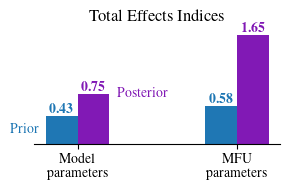

In [53]:
fig = plt.figure(figsize=(3,2))
ax = fig.add_subplot(111)

inds = np.arange(2)
labels = ['Model\nparameters', 'MFU\nparameters']
ax.bar(inds-0.1,Tprior, width=0.2)
ax.bar(inds+0.1, Tposterior, width=0.2, color='#8119b5')
ax.set_xticks(inds)
ax.set_xticklabels(labels)

for ind, T in zip(inds, Tprior):
    ax.annotate(rf'\textbf{{{T:.2f}}}', (ind-.1, T), va='bottom', ha='center', color='C0')
for ind, T in zip(inds, Tposterior):
    ax.annotate(rf'\textbf{{{T:.2f}}}', (ind+.1, T), va='bottom', ha='center', color='#8119b5')

ax.annotate('Prior', (inds[0]-.25, Tprior.iloc[0]/2), ha='right', va='center', color='C0')
ax.annotate('Posterior', (inds[0]+.25, Tposterior.iloc[0]), ha='left', va='center', color='#8119b5')

ax.set_yticks([])    
ax.spines[['top','right','left']].set_visible(False)
ax.set_title('Total Effects Indices')

fig.tight_layout()
fig.savefig(f'{results_dir}/prior_vs_post_indices.png', dpi=300, transparent=True)

Then maybe the best thing to avoid confusion is to consider just the numerator of the index
$$
T_i V = E(V[f|X_i])
$$

In [54]:
prior_numerators = mprior.results['Total Effects'] * mprior.V
posterior_numerators = mposterior.results['Total Effects'] * mposterior.V

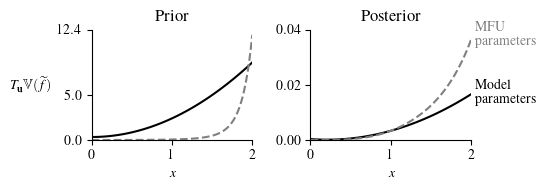

In [55]:
fig = plt.figure(figsize=(5,2))
axs = fig.subplots(1, 2)

MFUcolor='grey'

axs[0].plot(data_x, prior_numerators.iloc[0], 'k-')
axs[0].plot(data_x, prior_numerators.iloc[1], color=MFUcolor, ls='--', lw=1.5)
axs[0].set_title("Prior")
axs[0].set_ylabel(r'$T_{\mathbf{u}}\mathbb{V}(\widetilde{f})$', rotation=0, ha='right', va='center')
axs[0].set_yticks([0,5,axs[0].get_ylim()[-1]])

axs[1].plot(data_x, posterior_numerators.iloc[0], 'k-')
axs[1].plot(data_x, posterior_numerators.iloc[1], color=MFUcolor, ls='--', lw=1.5)
axs[1].set_title("Posterior")
fig.text(.96, 0.51, "Model\nparameters", va='center', ha='left')
fig.text(.96, 0.80, "MFU\nparameters", va='center', ha='left', color=MFUcolor)
axs[1].set_yticks([0,0.02,0.04])

for ax in axs:
    ax.spines[['top','right']].set_visible(False)
    ax.set_xlabel(r'$x$')
    ax.set_ylim([0,ax.get_ylim()[1]])
    ax.set_xlim([0,2])

fig.tight_layout()
fig.savefig(f'{results_dir}/prior_vs_posterior_numerators_x.png', dpi=300, transparent=True, bbox_inches='tight')